In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
import os
import torch
import numpy as np
from bispectral_networks.logger import load_checkpoint
from bispectral_networks.analysis.plotting import image_grid

ModuleNotFoundError: No module named 'torch'

In [107]:
# Dataset Imports
from bispectral_networks.data.datasets import MNISTExemplars, TransformDataset
from bispectral_networks.data.transforms import CyclicTranslation2D, CenterMean, UnitStd, Ravel
from skimage.transform import resize

In [108]:
# Plotting imports
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
sns.set(font_scale=1.5)
sns.set_style('dark')

# Bispectral Neural Networks - Translation Experiment

This notebook reproduces the plots for the translation experiment. It also allows the user to test the network on datasets generated with different random seeds, to examine the generality of the results. We examine the properties of the network with respect to three criteria:
- Invariance and Equivariance
- Generalization
- Robustness

In [109]:
save_dir = "figs/translation/"
os.makedirs(save_dir, exist_ok=True)

### Load Checkpoint

The default in this notebook is to use the pretrained model from the paper, which is located at `../logs/translation_model/`

Alternatively, the user can load a new model by changing the `log_path` below to the location of the log folder for that model.

In [150]:
log_path = "../logs/translation_model/"
checkpoint, config, weights = load_checkpoint(log_path)

In [151]:
checkpoint

BispectralTrainer(
  (loss): OrbitCollapse()
  (normalizer): L2Normalizer()
  (scheduler): <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f41b23e02e0>
  (model): BispectralEmbedding(
    (layers): ModuleList(
      (0): Bispectral(
        (W): CplxParameter(256, 256)
      )
      (1): RowNorm()
      (2): CplxToComplex()
    )
  )
)

In [112]:
print(weights.dtype)
print(weights.shape)

complex64
(256, 16, 16)


In [113]:
patch_size = config["dataset"]["pattern"]["params"]["patch_size"]

### Visualize Weights

**Real Components**

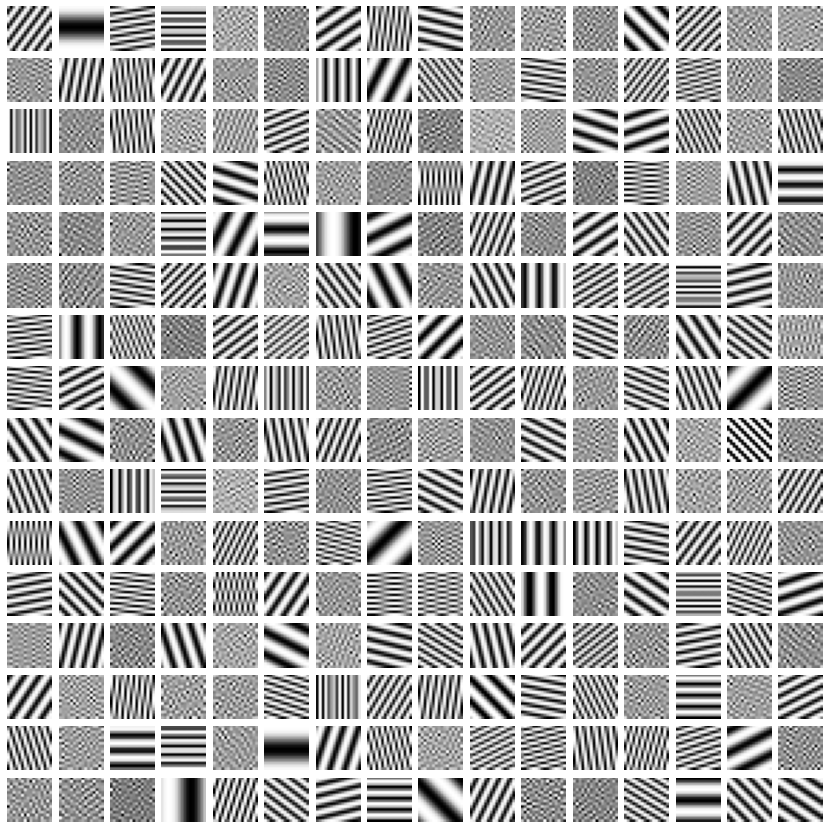

In [114]:
image_grid(weights.real, cmap="Greys_r", shape=(16, 16), figsize=(15, 15), share_range=False, save_name=os.path.join(save_dir, "W_real.pdf"))

**Imaginary Components**

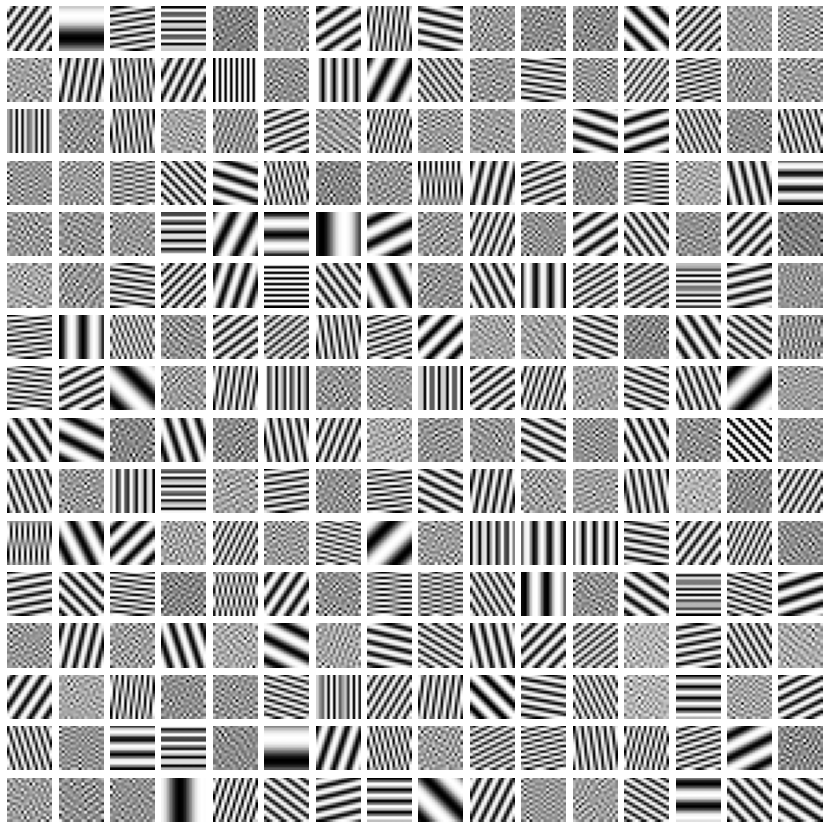

In [115]:
image_grid(weights.imag, cmap="Greys_r", shape=(16, 16), figsize=(15, 15), share_range=False, save_name=os.path.join(save_dir, "W_imag.pdf"))

## Evaluate Model

For all analyses, we use an out-of-distribution test dataset of never-before-seen images. While the network was trained on natural image patches from the Van Hateren dataset, we use exemplars from the MNIST dataset for all model evaluation analyses, to test the generality of the learned map. 

### Invariance / Equivariance Analysis
We first perform a qualitative analysis of the invariance and equivariance properties of the network. For this analysis, we randomly draw exemplars from the MNIST dataset, using one exemplar per digit and generating all 256 integer translations of each exemplar to form the image orbits. We then pass the data through the model, and examine the output of the first linear term $Wx$ and the output of the full network.

**Generate Dataset**

In [116]:
torch.random.seed()

# 1 exemplar per digit is randomly selected
pattern = MNISTExemplars(path="../datasets/mnist/mnist_train.csv", n_exemplars=1)

# Resize the images to the size of the patches the network was trained on
resized = torch.stack([torch.tensor(resize(x, (patch_size, patch_size))) for x in pattern.data])
pattern.data = resized

# Apply transformations
transform1 = CyclicTranslation2D(fraction_transforms=1.0, sample_method="linspace")
transform2 = CenterMean()
transform3 = UnitStd()
transform4 = Ravel()
inv_eq_dataset = TransformDataset(pattern, [transform1, transform2, transform3, transform4])
print(inv_eq_dataset.data.shape)

torch.Size([2560, 256])


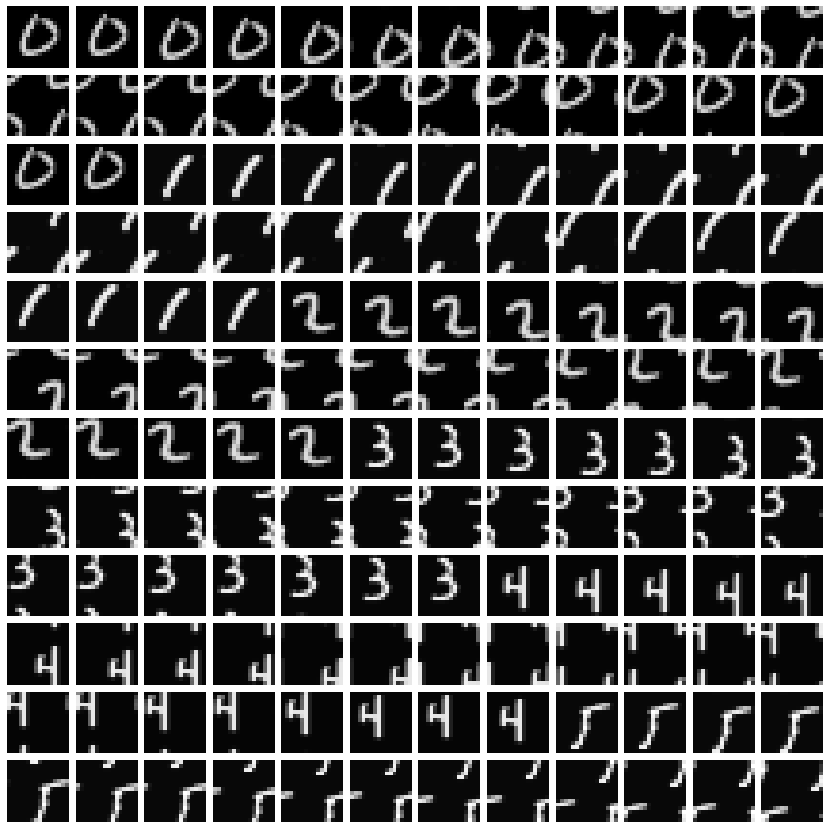

In [117]:
image_grid(inv_eq_dataset.data[::10][:144].reshape(-1, patch_size, patch_size), shape=(12, 12), figsize=(15, 15), cmap="Greys_r", save_name=os.path.join(save_dir, "test_examples.pdf"))

**Pass Data Through Model**

In [118]:
out, _ = checkpoint.model(inv_eq_dataset.data)
out = out.detach().numpy()
l_out = checkpoint.model.layers[0].forward_linear(inv_eq_dataset.data).detach().numpy()
l_out = l_out.real + 1j * l_out.imag

**First Linear Term (Equivariance)**

The plots below show the outputs of 3 neurons after the first linear term $Wx$ is computed, on the data below: a single digit swept linearly through a translation.  Each colored line represents a single neuron, the y-axis shows the neuron's response, and the x axis corresponds to the translation.

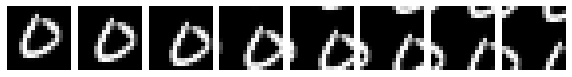

In [119]:
image_grid(inv_eq_dataset.data[::16][:8].reshape(-1, 16, 16), shape=(1, 8), cmap="Greys_r")

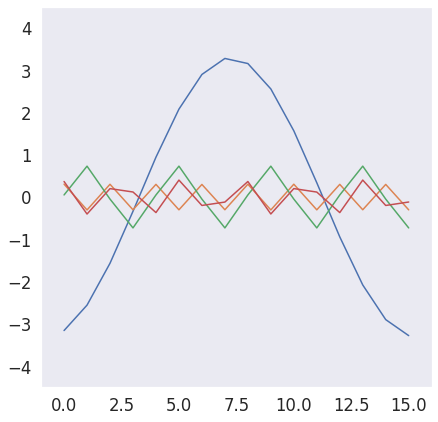

In [120]:
plt.figure(figsize=(7, 7))
plt.plot(l_out[::16][:16, [1, 13, 22, 3]].real,);
plt.axis([-1, 16, -4.5, 4.5]);
plt.savefig(os.path.join(save_dir, "equivariance-0.pdf"))

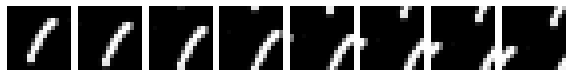

In [122]:
image_grid(inv_eq_dataset.data[::16][16:24].reshape(-1, 16, 16), shape=(1, 8), cmap="Greys_r")

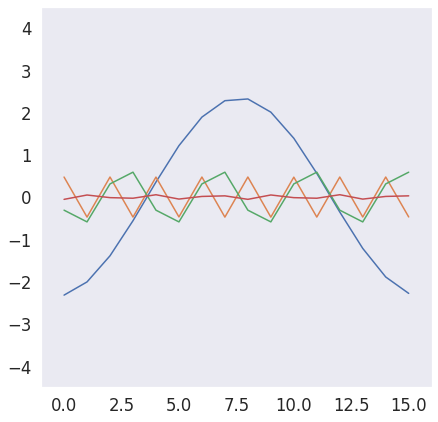

In [123]:
plt.figure(figsize=(7, 7))
plt.plot(l_out[::16][16:32, [1, 13, 22, 3]].real,);
plt.axis([-1, 16, -4.5, 4.5]);
plt.savefig(os.path.join(save_dir, "equivariance-1.pdf"))

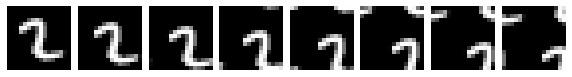

In [124]:
image_grid(inv_eq_dataset.data[::16][32:40].reshape(-1, 16, 16), shape=(1, 8), cmap="Greys_r")

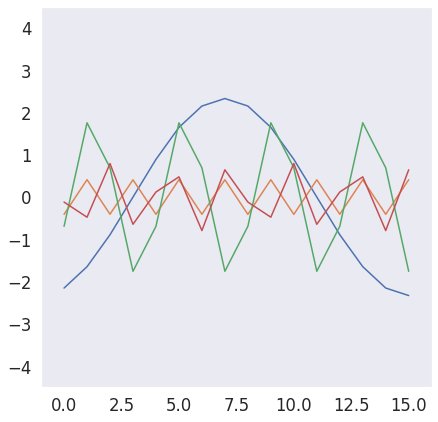

In [125]:
plt.figure(figsize=(7, 7))
plt.plot(l_out[::16][32:48, [1, 13, 22, 3]].real,);
plt.axis([-1, 16, -4.5, 4.5]);
plt.savefig(os.path.join(save_dir, "equivariance-2.pdf"))

**Invariance**

The plots below show the outputs of all neurons at the output of the network, computed on single digit swept linearly through a translation. Each colored line represents a single neuron, the y-axis shows the neuron's response, and the x axis corresponds to the translation.

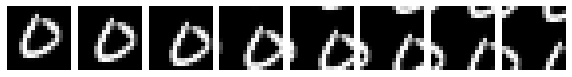

In [126]:
image_grid(inv_eq_dataset.data[::16][:8].reshape(-1, 16, 16), shape=(1, 8), cmap="Greys_r")

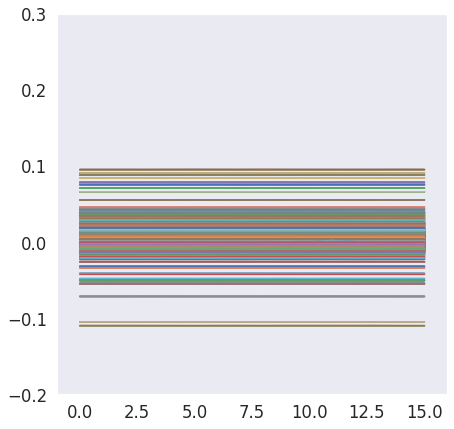

In [127]:
plt.figure(figsize=(7, 7))
plt.plot(out[::16][:16].real,);
plt.axis([-1, 16, -0.2, 0.3]);
plt.savefig(os.path.join(save_dir, "invariance-0.pdf"))

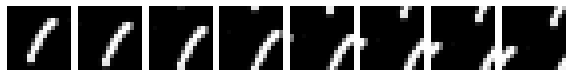

In [128]:
image_grid(inv_eq_dataset.data[::16][16:24].reshape(-1, 16, 16), shape=(1, 8), cmap="Greys_r")

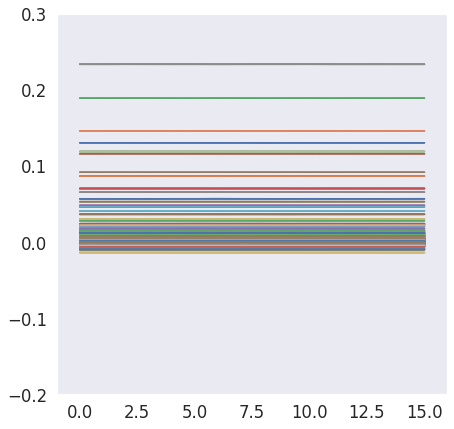

In [129]:
plt.figure(figsize=(7, 7))
plt.plot(out[::16][16:32].real,);
plt.axis([-1, 16, -0.2, 0.3]);
plt.savefig(os.path.join(save_dir, "invariance-1.pdf"))

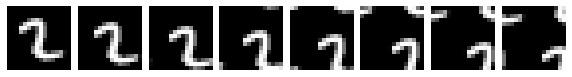

In [130]:
image_grid(inv_eq_dataset.data[::16][32:40].reshape(-1, 16, 16), shape=(1, 8), cmap="Greys_r")

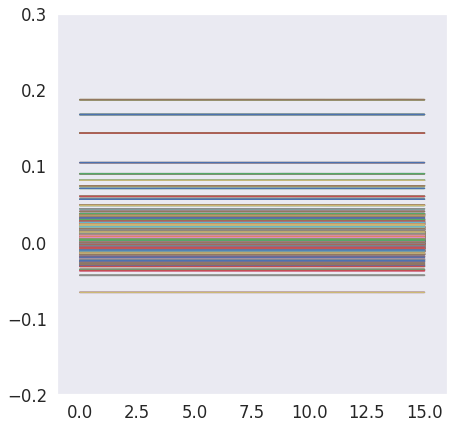

In [131]:
plt.figure(figsize=(7, 7))
plt.plot(out[::16][32:48].real,);
plt.axis([-1, 16, -0.2, 0.3]);
plt.savefig(os.path.join(save_dir, "invariance-2.pdf"))

## Generalization Analysis

We next quantify the generalization performance of the network on the test data. Here, we use a smaller subset of the rotations, to make it computationally feasible to compute pairwise distances between the network outputs for all datapoints. We then examine the k-nearest neighbors of each datapoint and examine the fraction of k that are correctly classified as within-orbit. K is set to the number of elements in the orbit. Here, since 10% of the orbit was selected (fraction_transforms parameter in CyclicTranslation2D), the orbit has 25 elements. A model that perfectly collapses orbits should achieve 100% classification accuracy on this metric.

In [132]:
from bispectral_networks.analysis.knn import knn_analysis

In [133]:
torch.random.seed()

# 1 exemplar per digit is randomly selected
pattern = MNISTExemplars(path="../datasets/mnist/mnist_train.csv", n_exemplars=1)

# Resize the images to the size of the patches the network was trained on
resized = torch.stack([torch.tensor(resize(x, (patch_size, patch_size))) for x in pattern.data])
pattern.data = resized

# Apply transformations
transform1 = CyclicTranslation2D(fraction_transforms=0.1, sample_method="linspace")
transform2 = CenterMean()
transform3 = UnitStd()
transform4 = Ravel()
knn_dataset = TransformDataset(pattern, [transform1, transform2, transform3, transform4])
print(knn_dataset.data.shape)

torch.Size([250, 256])


In [134]:
k = 25
embeddings, distance_matrix, knn_scores = knn_analysis(checkpoint.model, knn_dataset, k)

In [135]:
print("The model successfully classified {:.2f}% of the orbit on average.".format(knn_scores[0] * 100))
print("The model misclassified {:.2f}% of the orbit on average.".format(knn_scores[1] * 100))

The model successfully classified 100.00% of the orbit on average.
The model misclassified 0.00% of the orbit on average.


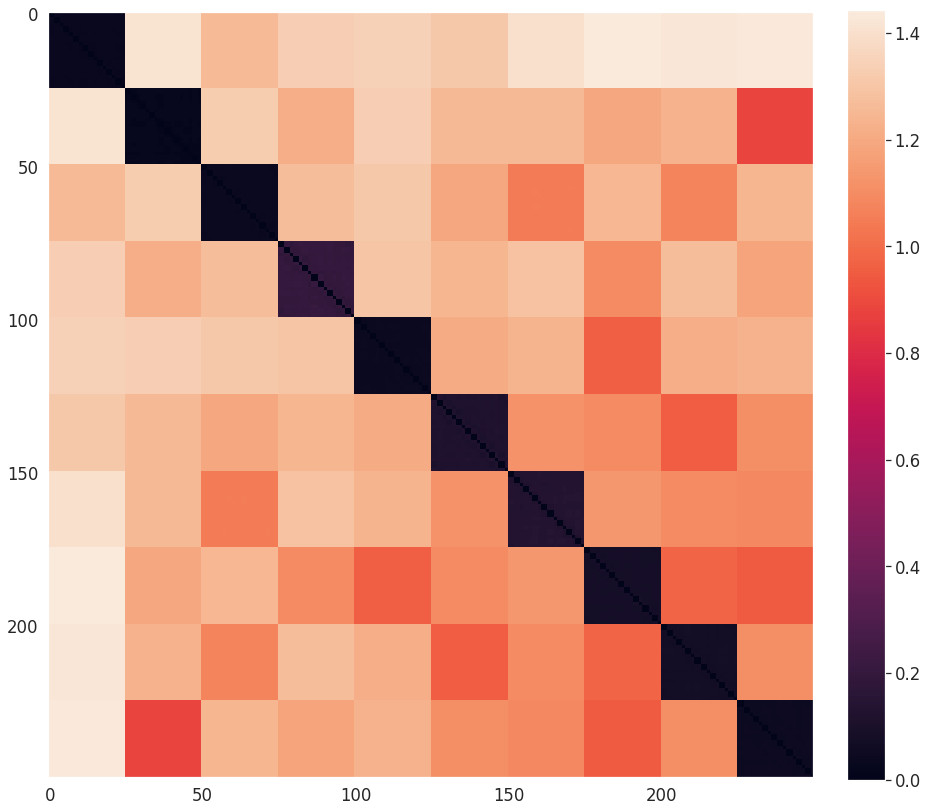

In [136]:
plt.figure(figsize=(15, 15))
im = plt.imshow(distance_matrix)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.savefig(save_dir + "test_distance_matrix.pdf")

## Robustness Analysis

Now, we analyze the robustness of the model through a simple adversarial example experiment. Here, we start with noise as the input, and optimize this input to yield a network output that is as close as possible to the network output for a target image. For this analysis, we select a single exemplar from the MNIST dataset as the target, and run the optimization starting from 100 different noise images to examine the range of results. Note that the BasicGradientDescent method often gets stuck in local minima that are farther from the target embedding than desired to be considered a meaningful "adversarial example." While such runs are interesting regardless, the approach should be rerun until the target reaches the margin. Fancier optimization methods could be used to escape these local minima, but here we use a vanilla model.

We find that, for this model, points that are close in embedding space will be (close to) equivalent up to the group action that the model has learned to be invariant to. In this notebook we use a margin of 0.1, which is larger than that used in the paper (since it tends to be difficult to drive the model lower). This means that the examples are more likely to look different from the target. Despite this, we find the same effect, which further demonstrates the robustness of this model.

In [137]:
from bispectral_networks.analysis.adversary import BasicGradientDescent
from bispectral_networks.analysis.plotting import animated_video

In [138]:
torch.random.seed()

# 1 exemplar per digit is randomly selected
pattern = MNISTExemplars(path="../datasets/mnist/mnist_train.csv", n_exemplars=1)

# Resize the images to the size of the patches the network was trained on
resized = torch.stack([torch.tensor(resize(x, (patch_size, patch_size))) for x in pattern.data])
pattern.data = resized

# Apply transformations
transform1 = CenterMean()
transform2 = UnitStd()
transform3 = Ravel()
robustness_dataset = TransformDataset(pattern, [transform1, transform2, transform3])
print(robustness_dataset.data.shape)

torch.Size([10, 256])


In [140]:
device = "cpu"
target_idx = np.random.randint(len(robustness_dataset.data))
target_image = robustness_dataset.data[target_idx].to(device)
target_image_tiled = torch.tensor(np.tile(target_image, (100, 1)))

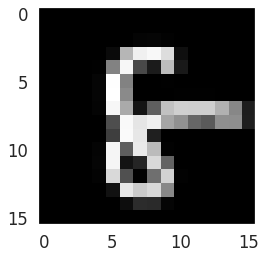

In [141]:
plt.imshow(target_image.reshape(patch_size, patch_size), cmap="Greys_r")

In [142]:
adversary = BasicGradientDescent(model=checkpoint.model, 
                                 target_image=target_image_tiled,
                                 margin=.1,
                                 lr=0.1,
                                 save_interval=10,
                                 print_interval=100,
                                 optimizer=torch.optim.Adam,
                                 device=device)

x_, target_embedding, embedding = adversary.train(max_iter=1000)

Iter: 100 | Distance: 0.1826067566871643
Iter: 200 | Distance: 0.1575019657611847
Iter: 300 | Distance: 0.15741576254367828
Iter: 400 | Distance: 0.15738968551158905
Iter: 500 | Distance: 0.15738004446029663
Iter: 600 | Distance: 0.15736788511276245
Iter: 700 | Distance: 0.15744701027870178
Iter: 800 | Distance: 0.15738239884376526
Iter: 900 | Distance: 0.15738935768604279
Iter: 1000 | Distance: 0.15743927657604218
Final Distance: 0.15743927657604218
Did not reach margin.


In [143]:
history = np.array([x.reshape(-1, patch_size, patch_size) for x in adversary.history])

In [144]:
history.shape

(100, 100, 16, 16)

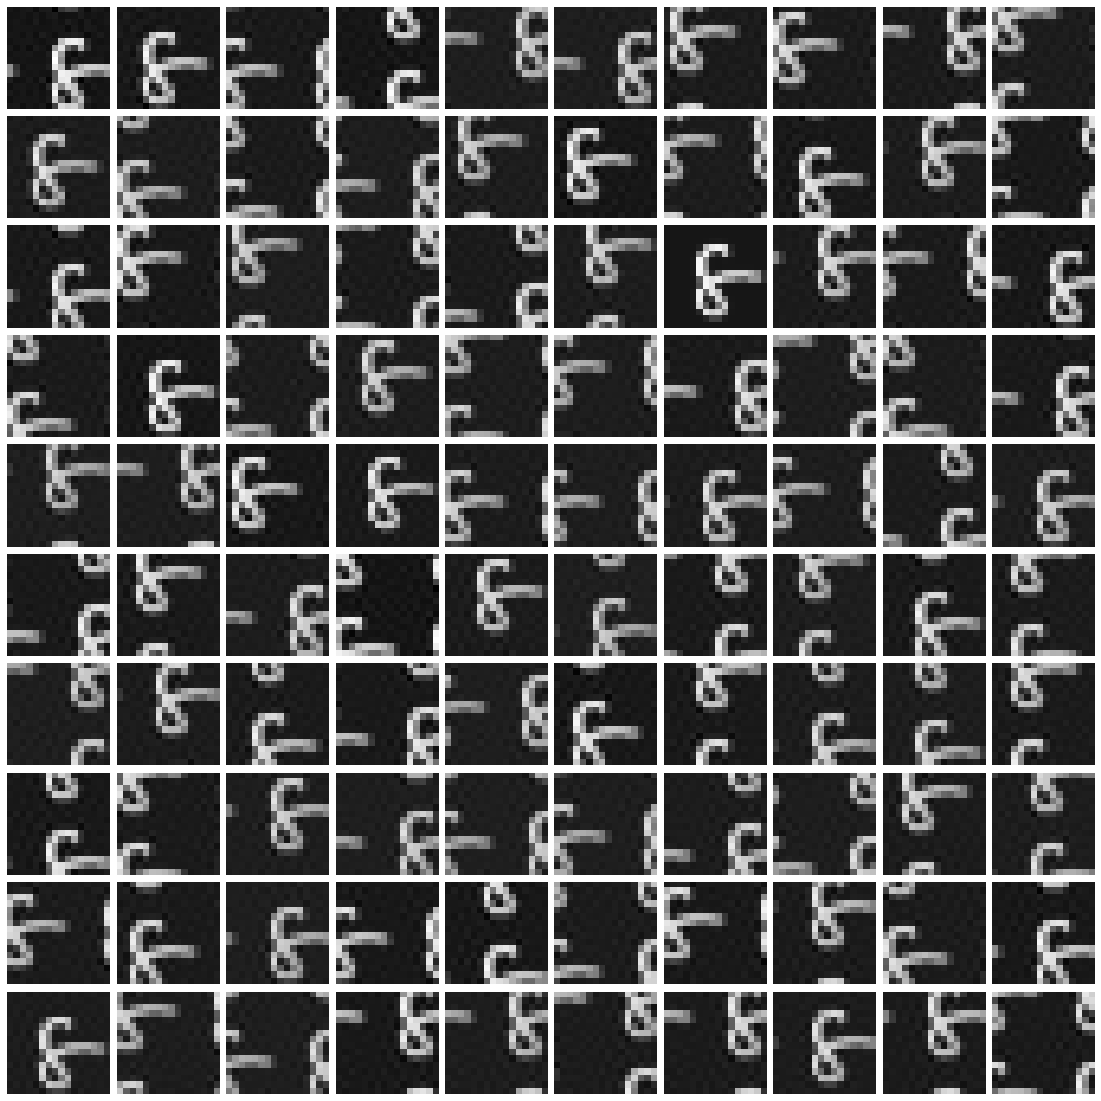

In [145]:
image_grid(history[-1], shape=(10, 10), cmap="Greys_r", figsize=(20, 20))
plt.savefig(os.path.join(save_dir, "adversary.pdf"))

**Visualizing the Optimization Process**

The below video shows the optimization of a single example image through gradient steps.

In [147]:
animated_video(history[:, 0], interval=100, cmap="Greys_r")